## First-order Markov Chain

To begin with, let's try to infer transition probabilities matrix from an observed sequence of states using a Dirichlet prior and custom likelihood. Sequence is a result of Markov Process with known transition matrix.


In [12]:
import pymc3 as pm
import numpy as np
from scipy import stats, optimize
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano.tensor.slinalg as nla
import theano

#idealized transition matrix corresponding to coarsening-upwards lithology
TR = np.array([[0.1, 0.7, 0.1, 0.1],[0.1, 0.1, 0.7, 0.1],[0.1, 0.1, 0.1, 0.7],[0.7, 0.1, 0.1, 0.1]])
N_states = TR.shape[0]

print('Number of states: %s\n'%N_states)
print('Transition matrix: \n%s\n'%TR)

stationary_dist = lambda X : nla.solve((tt.eye(N_states)-X+tt.ones((N_states, N_states))).T, tt.ones(shape=N_states))

print('Stationary distribution: %s'%stationary_dist(TR).eval())

Number of states: 4

Transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Stationary distribution: [0.25 0.25 0.25 0.25]


In [13]:
seq_len = 10000 #length of sequence to simulate
TR_c = TR.cumsum(axis=1)
seq = np.zeros((seq_len,), dtype=int)
for i in range(1,seq_len):
    seq[i] = np.sum(TR_c[seq[i-1]]<np.random.rand())
print('Observed sequence size: %s'%seq.shape)

Observed sequence size: 10000


#### Define PyMC model as follows:
$$P(z_t|z_{t-1}=s_i) = A_i, i=1...N $$
$$A_i \sim Dirichlet(a)$$
Then, probability of an observed sequence is defined as
$$P(\vec{z}|A)=\prod_{t=1}^{T} {P(z_t|z_{t-1};A)}=\prod_{t=1}^{T} {A_{ij}}$$
or, applying log-transformation:
$$logP(\vec{z}|A)=\sum_{t=1}^{T} {logP(z_t|z_{t-1};A)}=\sum_{t=1}^{T} {logA_{ij}}$$

In [14]:
with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    P0 = stationary_dist(A)
    out = pm.Potential('out', tt.log(P0[seq[0]]) + tt.sum(pm.Categorical.dist(A[seq[:-1]]).logp(seq[1:])))
    start = pm.find_MAP()
    trace = pm.sample(start=start) 

logp = -9,264.6, ||grad|| = 0.0021696: 100%|██████████| 12/12 [00:00<00:00, 221.40it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:53<00:00, 74.46draws/s] 


We can now compare the inferred transition matrix with the source one. Also, trace plots are useful to evaluate MCMC performance. Below are MCMC chain traces (left) and histogram of transition matrix posterior (right).

Source transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Inferred transition matrix: 
[[0.09527684 0.69945781 0.09923177 0.10603358]
 [0.08881525 0.06990223 0.75628133 0.08500119]
 [0.09994322 0.10048764 0.10503334 0.6945358 ]
 [0.68664461 0.09766849 0.12012288 0.09556403]]

Stationary distribution: 
[0.24468816 0.23902412 0.26309826 0.25318946]

Trace plot:


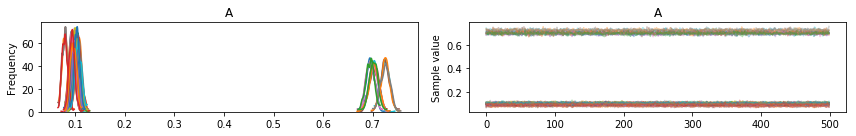

In [15]:
TR_post = np.array(trace['A'])
print('Source transition matrix: \n%s\n' %TR)
print('Inferred transition matrix: \n%s\n' %TR_post[-1])
print('Stationary distribution: \n%s\n' %stationary_dist(TR_post[-1]).eval())
print('Trace plot:')
pm.traceplot(trace);

Alternatively, instead of using DesnityDist with likelihood function, we can define a child class to PyMC Categorical and override methods as needed.

In [16]:
class MarkovChain(pm.Categorical):
    def __init__(self, p=None, *args, **kwargs):
        super().__init__(p, *args, **kwargs)
        self.p = p
        self.mode = tt.cast(0,dtype='int64')
        
    def logp(self, x):
        p0 = stationary_dist(self.p)
        return tt.log(p0[x[0]]) + tt.sum(pm.Categorical.dist(self.p[x[:-1]]).logp(x[1:]))
    
N_states = 4
with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    out = MarkovChain('out', p=A, shape=seq.shape[0], observed=seq)
    star = pm.find_MAP()
    trace = pm.sample(start=start)
model

logp = -9,264.6, ||grad|| = 0.0021696: 100%|██████████| 12/12 [00:00<00:00, 295.91it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:54<00:00, 74.06draws/s] 


Inferred transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Inferred transition matrix: 
[[0.09586745 0.71176357 0.09029046 0.10207852]
 [0.09734014 0.07789391 0.73310637 0.09165959]
 [0.10605953 0.10102473 0.11706229 0.67585345]
 [0.67904142 0.10751156 0.11904173 0.0944053 ]]

Stationary distribution: 
[0.24363961 0.24575043 0.26242398 0.24818598]

Trace plot:


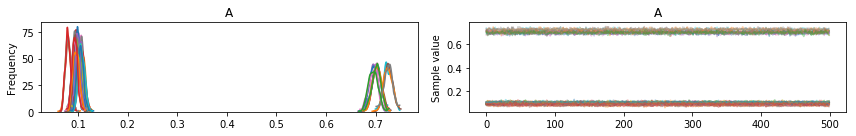

In [17]:
TR_post = np.array(trace['A'])
print('Inferred transition matrix: \n%s\n' %TR)
print('Inferred transition matrix: \n%s\n' %TR_post[-1])
print('Stationary distribution: \n%s\n' %stationary_dist(TR_post[-1]).eval())
print('Trace plot:')
pm.traceplot(trace);

## Hidden Markov Model

Here, we consider a simple HMM with Gaussian emissions. For now, we assume that the emission distributions for all states are Gaussian and known. Below are the emission pdf's corresponding to each of the four states.

Emission distributions: 



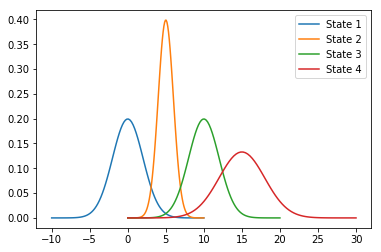

In [18]:
import scipy.stats as stats
x = np.linspace(-10, 10, 100)
ems_mu = np.array([0, 5, 10, 15]);
ems_sd = np.array([2, 1, 2, 3]);

print('Emission distributions: \n')
for i in range(0,4):
    x = np.linspace(-5*ems_sd[i]+ems_mu[i], 5*ems_sd[i]+ems_mu[i], 100)
    plt.plot(x, stats.norm.pdf(x, ems_mu[i], ems_sd[i]), label='State %s'%(i+1))
plt.legend();

We now define the model as:

$$P(z_t|z_{t-1}=s_i) = A_i, i=1...N $$
$$A_i \sim Dirichlet(a)$$

$$P(\vec{z}| A, \boldsymbol{\mu}, \boldsymbol{\sigma}) = \sum_{\vec{z}}{\prod_{t=1}^{T}{P(x_t|z_t)}\prod_{t=1}^{T}{P(z_t|z_{t-1}; A)}} = \sum_{\vec{z}}{\prod_{t=1}^{T}{P(x_t|z_t; \mu_{z_t}, \sigma_{z_t})}\prod_{t=1}^{T}{P(z_t|z_{t-1}; A)}}$$
Since sampling of the model can take quite a long time, for now we take unobserved sequence of states to be only 2000 samples long.

In [19]:
seq1 = seq[0:2000]
seq_ems = np.array(pm.Normal.dist(mu=ems_mu[seq1], sd=ems_sd[seq1]).random())

In [20]:
class HMMEmission(pm.Continuous):
    def __init__(self, mu=None, sd=None, states=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mu = tt.constant(mu)
        self.sd = tt.constant(sd)
        self.states = states
        self.mode = tt.cast(0,dtype='float64')

    def logp(self, x):
        return tt.sum(pm.Normal.dist(self.mu[states], self.sd[states]).logp(x))
    

with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    states = MarkovChain('states', A, shape=seq_ems.shape[0], dtype = 'int64')
    ems = HMMEmission('ems', mu=ems_mu, sd=ems_sd, states=states, observed = seq_ems)
    start = pm.find_MAP()
    trace = pm.sample(start=start)
model

logp = -25,822, ||grad|| = 0.00082051: 100%|██████████| 26/26 [00:00<00:00, 472.10it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [A]
>CategoricalGibbsMetropolis: [states]
Sampling 4 chains: 100%|██████████| 4000/4000 [16:15<00:00,  2.29draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Summary

In [26]:
TR_post = np.array(trace['A'][-1])
seq_inf = np.array(trace['states'][-1])

print('Inferred transition matrix: \n%s\n'%TR_post)
print('Actual sequence of hidden states: \n%s\n'%seq1)
print('Inferred sequence of hidden states: \n%s\n'%seq_inf)
print('Error (fraction of mismatching states): %s\n'%(np.sum(np.not_equal(seq1, seq_inf))/seq_inf.shape[0]))

Inferred transition matrix: 
[[0.13409886 0.69896327 0.06231378 0.10462409]
 [0.10696545 0.06925389 0.69928786 0.1244928 ]
 [0.10507227 0.11495988 0.09393243 0.68603541]
 [0.75006541 0.08986548 0.08111314 0.07895597]]

Actual sequence of hidden states: 
[0 1 2 ... 0 3 0]

Inferred sequence of hidden states: 
[0 1 2 ... 0 3 0]

Error (fraction of mismatching states): 0.096



## Current considerations

* Sampling is too slow, need to implement F-B algorithm or switch to different implementation
* Even with known emission distributions, no noise and relatively long sequence (2000 points) transition matrix is hard to infer
* In our application, there is no guarantee that the hidden states would follow any stationary Markov Chain. Maybe we could omit this assumption, and condition hidden states based on the combination of templates they come from (probability aggregation we discussed before)